In [1]:
import os
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, f1_score
import torch.nn.functional as F
import functools
from torch.optim import Adam
import torchvision.transforms as transforms
import os

In [2]:
# --------------------------
# Dataset 定義
# --------------------------
class PCamDataset(Dataset):
    def __init__(self, h5_x_path, h5_y_path=None, transform=None):
        self.x_path = h5_x_path
        self.y_path = h5_y_path
        self.transform = transform
        self.has_labels = h5_y_path is not None

        with h5py.File(h5_x_path, 'r') as x_file:
            self.length = len(x_file['x'])

        if self.has_labels:
            with h5py.File(h5_y_path, 'r') as y_file:
                self.labels = y_file['y'][:]

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        with h5py.File(self.x_path, 'r') as x_file:
            image = x_file['x'][idx].astype(np.uint8)

        image = transforms.ToPILImage()(image)
        if self.transform:
            image = self.transform(image)

        if self.has_labels:
            label = self.labels[idx].item()
            return image, label
        else:
            return image

# --------------------------
# パスと設定
# --------------------------
TRAIN_X = '/home/gotou/Medical/camelyonpatch_level_2_split_test_x.h5'
TRAIN_Y = '/home/gotou/Medical/camelyonpatch_level_2_split_train_y.h5'
VAL_X   = '/home/gotou/Medical/valid_x_uncompressed.h5'
VAL_Y   = '/home/gotou/Medical/valid_y_uncompressed.h5'
TEST_X  = '/home/gotou/Medical/camelyonpatch_level_2_split_test_x.h5'
TEST_Y  = '/home/gotou/Medical/camelyonpatch_level_2_split_test_y.h5'

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# --------------------------
# Transform
# --------------------------
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(96, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.05),
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15)),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.RandomApply([transforms.RandomSolarize(threshold=0.5, p=0.3)], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
])

eval_transform = transforms.Compose([
    transforms.Resize(96),
    transforms.CenterCrop(96),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# --------------------------
# Dataloader
# --------------------------
batch_size = 128
train_ds = PCamDataset(TRAIN_X, TRAIN_Y, transform=train_transform)
val_ds   = PCamDataset(VAL_X, VAL_Y, transform=eval_transform)
test_ds  = PCamDataset(TEST_X, TEST_Y, transform=eval_transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4)

# --------------------------
# モデル定義
# --------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
for param in model.parameters():
    param.requires_grad = True

model.fc = nn.Sequential(
    nn.BatchNorm1d(model.fc.in_features),
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),
    nn.Linear(512, 1)
)
model = model.to(device)

# --------------------------
# 損失関数・最適化・スケジューラ
# --------------------------
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=30)

# --------------------------
# 学習と評価関数
# --------------------------
def train_one_epoch(epoch):
    model.train()
    running_loss = 0.0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch}"):
        imgs, labels = imgs.to(device), labels.float().unsqueeze(1).to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    scheduler.step()
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch} Loss: {epoch_loss:.4f}")
    return epoch_loss

def evaluate(loader, split='Val'):
    model.eval()
    all_labels = []
    all_probs = []
    all_preds = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).long().squeeze()

            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.squeeze().cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = np.mean(np.array(all_labels) == np.array(all_preds))
    roc_auc = roc_auc_score(all_labels, all_probs)
    f1 = f1_score(all_labels, all_preds)

    print(f"{split} Metrics:")
    print(f"  Accuracy: {accuracy * 100:.2f}%")
    print(f"  ROC-AUC: {roc_auc:.4f}")
    print(f"  F1 Score: {f1:.4f}")

    return {
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'f1': f1,
        'probs': all_probs,
        'labels': all_labels
    }

# --------------------------
# メイン訓練ループ
# --------------------------
def main():
    best_val_roc_auc = 0
    history = {
        'train_loss': [],
        'val_metrics': [],
        'test_metrics': None
    }

    for epoch in range(1, 30):
        train_loss = train_one_epoch(epoch)
        history['train_loss'].append(train_loss)

        val_metrics = evaluate(val_loader, 'Val')
        history['val_metrics'].append(val_metrics)

        if val_metrics['roc_auc'] > best_val_roc_auc:
            best_val_roc_auc = val_metrics['roc_auc']
            torch.save(model.state_dict(), 'best_resnet50_pcam.pth')
            print(f"Best model saved with ROC-AUC: {best_val_roc_auc:.4f}")

    print("\nEvaluating on test set with best model...")
    model.load_state_dict(torch.load('best_resnet50_pcam.pth'))
    test_metrics = evaluate(test_loader, 'Test')
    history['test_metrics'] = test_metrics

    return history

if __name__ == '__main__':
    history = main()


Epoch 1: 100%|██████████| 256/256 [00:44<00:00,  5.79it/s]


Epoch 1 Loss: 0.7608
Val Metrics:
  Accuracy: 47.32%
  ROC-AUC: 0.4519
  F1 Score: 0.3646
Best model saved with ROC-AUC: 0.4519


Epoch 2:  21%|██        | 54/256 [00:10<00:37,  5.38it/s]


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, f1_score
import matplotlib.pyplot as plt

def evaluate(loader, split='Val'):
    model.eval()
    all_labels = []
    all_probs = []
    all_preds = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).long().squeeze()

            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.squeeze().cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    accuracy = np.mean(all_labels == all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)
    f1 = f1_score(all_labels, all_preds)

    print(f"{split} Metrics:")
    print(f"  Accuracy: {accuracy * 100:.2f}%")
    print(f"  ROC-AUC: {roc_auc:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(f'{split} Confusion Matrix')
    plt.show()

    return {
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'f1': f1,
        'probs': all_probs,
        'labels': all_labels
    }


Test Metrics:
  Accuracy: 85.23%
  ROC-AUC: 0.9587
  F1 Score: 0.8339


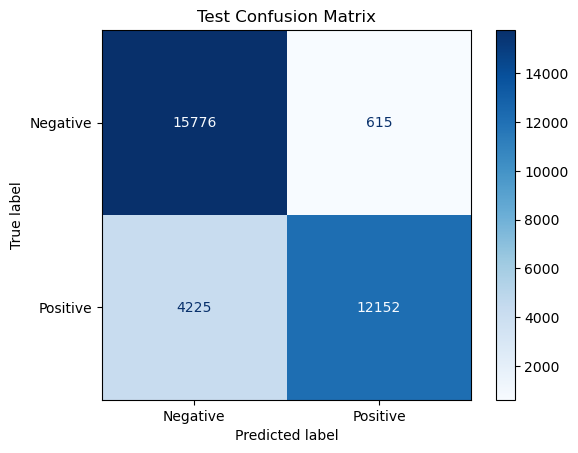

In [ ]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

model.fc = nn.Sequential(
    nn.BatchNorm1d(model.fc.in_features),  
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),
    nn.Linear(512, 1)
)

model.load_state_dict(torch.load('/home/gotou/Medical/best_resnet50_pcam.pth'))
model = model.to(device)
model.eval()

test_metrics = evaluate(test_loader, 'Test') 